In [1]:
import requests
import pandas as pd
import json
import pprint
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import ttest_ind

## Get Data

In [2]:
ID = 262237932 # Steam ID3, https://www.steamidfinder.com/
r = requests.get("https://api.opendota.com/api/players/{}/matches".format(ID))

In [3]:
matches = json.loads(r.text)

In [4]:
data = pd.DataFrame(matches)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   match_id       1177 non-null   int64  
 1   player_slot    1177 non-null   int64  
 2   radiant_win    1177 non-null   bool   
 3   duration       1177 non-null   int64  
 4   game_mode      1177 non-null   int64  
 5   lobby_type     1177 non-null   int64  
 6   hero_id        1177 non-null   int64  
 7   start_time     1177 non-null   int64  
 8   version        79 non-null     float64
 9   kills          1177 non-null   int64  
 10  deaths         1177 non-null   int64  
 11  assists        1177 non-null   int64  
 12  skill          520 non-null    float64
 13  leaver_status  1177 non-null   int64  
 14  party_size     244 non-null    float64
dtypes: bool(1), float64(3), int64(11)
memory usage: 130.0 KB


In [6]:
data.head()

,match_id,player_slot,radiant_win,duration,game_mode,lobby_type,hero_id,start_time,version,kills,deaths,assists,skill,leaver_status,party_size
0,6019979286,130,False,2394,22,0,35,1622456466,NaN,8,9,15,1.0,0,1.0
1,6019272240,0,True,2620,22,0,86,1622404328,NaN,8,9,25,1.0,0,1.0
2,6018438663,129,True,3048,22,0,62,1622373025,NaN,3,15,18,1.0,0,1.0
3,6014955452,3,True,2462,22,0,105,1622200484,NaN,6,6,11,NaN,0,1.0
4,6014833305,128,True,2750,22,0,105,1622193893,NaN,10,9,7,1.0,0,1.0


## Exploratory Data Analysis

In [7]:
sorted(data.player_slot.unique()) # 0-127 - Radiant, 128-255 - Dire

[0, 1, 2, 3, 4, 128, 129, 130, 131, 132]

In [8]:
data['radiant_team'] = data.player_slot.apply(lambda x: True if x in range(128) else False)

In [9]:
data.radiant_team.value_counts() # за Dire команду игр больше, но разница небольшая

False    597
True     580
Name: radiant_team, dtype: int64

In [10]:
data.game_mode.unique() # расшифровка: https://github.com/odota/dotaconstants/blob/master/json/game_mode.json

array([22,  4,  3,  2,  5,  1, 12], dtype=int64)

In [11]:
data.game_mode.value_counts() # больше всего игр сыграно в all_draft (22) и all_pick (1)

22    763
1     283
4      92
5      18
3      13
2       5
12      3
Name: game_mode, dtype: int64

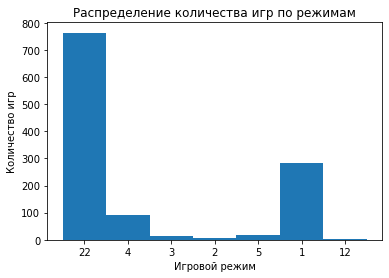

In [12]:
plt.hist(data.game_mode.astype(str),
         bins=np.arange(len(data.game_mode.unique()) + 1) - 0.5) # чтобы метки стояли в центре
plt.title('Распределение количества игр по режимам')
plt.xlabel('Игровой режим')
plt.ylabel('Количество игр')
plt.show()

In [13]:
data.lobby_type.unique() # 0 - normal, 7 - ranked, 9 - battle cup

array([0, 7, 9], dtype=int64)

In [14]:
data['lobby_type_str'] = data.lobby_type.apply(lambda x: 'normal' if x == 0 else ('ranked' if x == 7 else 'battle_cup'))

In [15]:
data.lobby_type_str.value_counts()

normal        1033
ranked         143
battle_cup       1
Name: lobby_type_str, dtype: int64

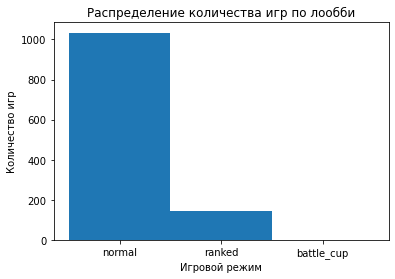

In [16]:
plt.hist(data.lobby_type_str.astype(str),
         bins=np.arange(len(data.lobby_type_str.unique()) + 1) - 0.5) # чтобы метки стояли в центре
plt.title('Распределение количества игр по лообби')
plt.xlabel('Игровой режим')
plt.ylabel('Количество игр')
plt.show()

In [17]:
data.party_size.unique()

array([ 1.,  2.,  4.,  3.,  5., nan])

In [18]:
data.party_size.value_counts(dropna=False)
# очень много игр имеют nan, возможно, в какой-то момент статистика не собиралась

NaN    933
1.0    111
2.0     60
3.0     30
5.0     25
4.0     18
Name: party_size, dtype: int64

In [19]:
data[data.party_size.isna()].tail(15)
# в основном такие игры в конце датафрейма, а он отсортирован по start_time,
# значит на ранних этапах игры такая статистика не велась

,match_id,player_slot,radiant_win,duration,game_mode,lobby_type,hero_id,start_time,version,kills,deaths,assists,skill,leaver_status,party_size,radiant_team,lobby_type_str
1162,1544435091,132,True,4775,1,0,105,1434028073,NaN,12,13,8,NaN,0,NaN,False,normal
1163,1543223046,131,False,3360,1,0,105,1433987687,NaN,15,7,9,NaN,0,NaN,False,normal
1164,1543166734,4,True,2481,1,0,105,1433984165,NaN,10,5,4,NaN,0,NaN,True,normal
1165,1543039899,130,False,3289,1,0,105,1433974758,NaN,24,9,6,NaN,0,NaN,False,normal
1166,1541731825,0,False,3156,1,0,5,1433934877,NaN,6,15,12,NaN,0,NaN,True,normal
1167,1500584675,128,True,3051,1,0,5,1432557151,NaN,6,14,14,NaN,0,NaN,False,normal
1168,1499161980,130,False,1948,1,0,86,1432495212,NaN,2,7,9,NaN,0,NaN,False,normal
1169,1487911323,132,False,3230,1,0,59,1432127647,NaN,30,16,15,NaN,0,NaN,False,normal
1170,1486180811,2,True,1982,1,0,43,1432056478,NaN,5,4,8,NaN,0,NaN,True,normal
1171,1485983746,131,True,2472,1,0,101,1432050666,NaN,7,7,7,NaN,0,NaN,False,normal


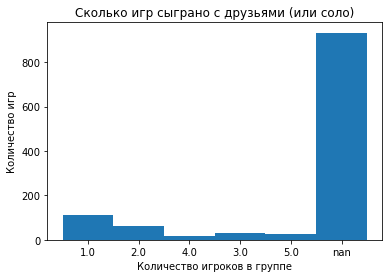

In [20]:
plt.hist(data.party_size.astype(str),
         bins=np.arange(len(data.party_size.unique()) + 1) - 0.5) # чтобы метки стояли в центре
plt.title('Сколько игр сыграно с друзьями (или соло)')
plt.xlabel('Количество игроков в группе')
plt.ylabel('Количество игр')
plt.show()

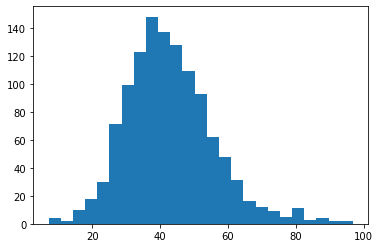

In [21]:
plt.hist(data.duration / 60, bins=25)
plt.show()

### Выводы (1)
- За radiant и dire команды я сыграл почти равное количество игр
- Больше всего наиграл в формате all_draft и all_pick
- Почти не играю в ranked игры, только обычные
- С увеличением числа игроков в моей группе количество игр уменьшается -- проще сыграть одному, чем собираться впятером
- В основном игры длятся 40 минут, хотя есть всплеск на 80 минутах

## Гипотезы
Больше всего мне нравится персонаж Techies (игроки доты меня сейчас возненавидят), поэтому смотреть будем на него. Techies -- такой персонаж, который в конце игры вряд ли сможет помочь выиграть, но и не даст проиграть, в результате чего игры будут затягиваться. Отсюда **первая гипотеза**: игры с Techies будут длиться больше среднего. **Вторая гипотеза** отчасти исходит от игрового сообщества, где бытует мнение, что Techies в конце игры не сможет выиграть. Попробуем проверить, являются ли долгие игры с Techies проигрышными. Ну и напоследок проверим **третью гипотезу** о том, что с другими игроками в группе (то есть при игре с друзьями, а не соло), процент побед будет ниже, чем при игре одному, ведь с командой ллюди часто играют не из-за скилла, а из-за дружеских отношений.

#### Первая гипотеза

In [22]:
data['start_time'] = pd.to_datetime(data['start_time'], unit='s').dt.date
year2018 = data[data['start_time'] > datetime.date(2018, 1, 1)]
# для проверки первой гипотезы возьмём только последние три года,
# так как длительность матча сильно зависит от последних обновлений

In [23]:
r2 = requests.get("https://api.opendota.com/api/heroes") # найдём id персонажей
heroes = pd.DataFrame(json.loads(r2.text))

In [24]:
heroes[heroes['localized_name'] == 'Techies'] # 6 ног - по 2 на каждого гоблина-техника

,id,name,localized_name,primary_attr,attack_type,roles,legs
103,105,npc_dota_hero_techies,Techies,int,Ranged,"[Nuker, Disabler]",6


In [25]:
techies = year2018[year2018['hero_id'] == 105]['duration'].values
no_techies = year2018[year2018['hero_id'] != 105]['duration'].values

In [26]:
print('Игр с Techies:', len(techies))
print('Игр без Techies:', len(no_techies))

Игр с Techies: 278
Игр без Techies: 354


In [27]:
stat, p = ttest_ind(techies, no_techies)
print('Statistics = %.4f, p-value = %.4f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Гипотеза принимается')
else:
    print('Гипотеза отклоняется')

Statistics = 2.9856, p-value = 0.0029
Гипотеза отклоняется


#### Вторая гипотеза
Что такое *долгие игры*? В нашем случае возьмём как порог 60 минут.

In [28]:
# создали столбец с победами
data['victory'] = 0
data.loc[(data['radiant_team'] == True) & (data['radiant_win'] == True), 'victory'] = 1
data.loc[(data['radiant_team'] == False) & (data['radiant_win'] == False), 'victory'] = 1

In [29]:
long = data[data['duration'] > 60 * 60]

In [30]:
long_techies = long[long['hero_id'] == 105]
long_no_techies = long[long['hero_id'] != 105]

In [31]:
print('Долгих игр с Techies:', len(long_techies))
print('Долгих игр без Techies:', len(long_no_techies))

Долгих игр с Techies: 46
Долгих игр без Techies: 57


In [32]:
print('Доля выигранных долгих игр с Techies: %.3f' % long_techies['victory'].mean())
print('Доля выигранных долгих игр без Techies: %.3f' % long_no_techies['victory'].mean())
# Получается, что в долгих играх на Techies я всё-таки скорее выиграю

Доля выигранных долгих игр с Techies: 0.587
Доля выигранных долгих игр без Techies: 0.491


#### Третья гипотеза

In [33]:
# Здесь нам всё-таки стоит избавить от NaN
temp = data[data['party_size'].notna()]

In [34]:
solo = temp[temp['party_size'] == 1]
no_solo = temp[temp['party_size'] != 1]

print('Соло игр:', len(solo))
print('Игр с друзьями:', len(no_solo))

Соло игр: 111
Игр с друзьями: 133


In [35]:
print('Доля побед при игре одному:', round(solo['victory'].mean(), 4))
print('Доля побед при игре с друзьями:', round(no_solo['victory'].mean(), 4))

Доля побед при игре одному: 0.5045
Доля побед при игре с друзьями: 0.5038


### Выводы (2)
- H1 отклоняется, Techies не затягивает игры
- H2 отклоняется, Techies выигрывает длинные игры
- H3 также отклоняется, разницы между играми соло и играми в команде нет